<img src="https://image.flaticon.com/icons/png/512/2394/2394119.png" width="300">

# Long-Term Return-on-Investment at Microsoft via Short-Term Proxies


Policy makers typically face the problem of wanting to estimate the treatment effect of some new incentives on long-run downstream interests. However, we only have historical data of older treatment options, and we haven't seen the long-run play out yet. We assume access to a long-term dataset where only past treatments were administered and a short-term dataset where novel treatments have been administered. We propose a surrogate based approach where we assume that the long-term effect is channeled through a multitude of available short-term proxies. Our work combines three major recent techniques in the causal machine learning literature: **surrogate indices**, **dynamic treatment effect estimation** and **double machine learning**, in a unified
pipeline. For more details, see this paper [here](https://arxiv.org/pdf/2103.08390.pdf).

In this case study, we will show you how to apply this unified pipeline to a ROI estimation problem at Microsoft. These methodologies have already been implemented into our [EconML](https://aka.ms/econml) library and you could do it with only a few lines of code.

### Summary

1. [Background](#Background)
2. [Data](#Data)
3. [Do Dynamic Adjustment with EconML](#Do-Dynamic-Adjustment-with-EconML)
4. [Train Surrogate Index](#Train-Surrogate-Index)
5. [Run DML to Learn ROI with EconML](#Run-DML-to-Learn-ROI-with-EconML)
6. [Model Evaluation](#Model-Evaluation)
7. [Extensions -- Including Heterogeneity in Effect](#Extensions----Including-Heterogeneity-in-Effect)
8. [Conclusions](#Conclusions)

# Background

Microsoft provides multiple montetary and resource investments to enterprice customers in support of products adoption, the sales manager would like to know which of these programs ("investments") are more successful than others? Specifically, we are interested in identifying the average treatment effect of each investment at some period $t$, on the cumulative outcome in the subsequent $m$ months. 

There are a few challenges to answer this question. First of all, we haven't fully observed the long-term revenue yet and we don't want to wait that long to evaluate a program. In addition, a careful causal modeling is required to correctly attribute the long-term ROI of multiple programs in a holistic manner, avoiding the biased estimate coming from confounding effect or double counting issues. 

The causal graph below shows how to frame this problem:

![](https://drive.google.com/uc?export=view&id=1joPt0TWIn_QTK3eAFe8VBQXIiARyBcZm)

**Methodology:** Our proposed adjusted surrogate index approach could address all the chanllenges above by assuming the long-term effect is channeled through some short-term observed surrogates and employing a dynamic adjustment step (`DynamicDML`) to the surrogate model in order to get rid of the effect from future investment, finally applying double machine learning (`DML`) techniques to estimate the ROI. 

The pipeline below tells you how to solve this problem step by step:
![](https://drive.google.com/uc?export=view&id=1VN94rJWbzzXiNl2y91NRXBXFAnCylaQN)

In [2]:
!pip install econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 4.0 MB/s 
     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 123 kB 49.5 MB/s 
     |████████████████████████████████| 356 kB 48.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491686 sha256=4c795f4d8f92197fba262ee3e2308d4b07816d671c79d432f0d1d935f3b3cdfb
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [3]:
# imports
from econml.data.dynamic_panel_dgp import SemiSynthetic
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

The **semi-synthetic data*** is comprised of 4 components:
 * **Surrogates:** short-term metrics that could represent long-term revenue
 * **Treatments:** different types of monetary investments to the end customers
 * **Outcomes:** cumulative long-term revenue
 * **Controls:** lagged surrogates and treatments, other time-invariant controls (e.g. demographics)

To build the semi-synthetic data we estimate a series of moments from a real-world dataset: a full covariance matrix of
all surrogates, treatments, and controls in one period and a series of linear prediction models (lassoCV) of each surrogate and
treatment on a set of 6 lags of each treatment, 6 lags of each surrogate, and time-invariant controls. Using these values, we draw new parameters from distributions matching the key characteristics of each family of parameters. Finally, we use these new
parameters to simulate surrogates, treatments, and controls by drawing a set of initial values from the covariance matrix and
forward simulating to match intertemporal relationships from the transformed prediction models. We use one surrogate to be the outcome of interests. Then we consider the effect of each treatment in period $t$ on the cumulative sum of outcome from following 4 periods. We can calculate the true treatment effects in the semi-synthetic data as a function of parameters from the linear prediction models.

The input data is in a **panel format**. Each panel corresponds to one company and the different rows in a panel correspond to different time period. 

Example:

||Company|Year|Features|Controls/Surrogates|T1|T2|T3|AdjRev|
|---|---|---|---|---|---|---|---|---|
|1|A|2018|...|...|\$1,000|...|...|\$10,000|
|2|A|2019|...|...|\$2,000|...|...|\$12,000|
|3|A|2020|...|...|\$3,000|...|...|\$15,000|
|4|A|2021|...|...|\$3,000|...|...|\$18,000|
|5|B|2018|...|...|\$0|...|...|\$5,000|
|6|B|2019|...|...|\$1,000|...|...|\$10,000|
|7|B|2020|...|...|\$0|...|...|\$7,000|
|8|B|2021|...|...|\$1,200|...|...|\$12,000|
|9|C|2018|...|...|\$1,000|...|...|\$20,000|
|10|C|2019|...|...|\$1,500|...|...|\$25,000|
|11|C|2020|...|...|\$500|...|...|\$18,000|
|12|C|2021|...|...|\$500|...|...|\$20,000|
 
 **For confidentiality reason, the data used in this case study is synthetically generated and the feature distributions don't exactly correspond to real distributions.*

In [4]:
# generate historical dataset (training purpose)
np.random.seed(43)
dgp = SemiSynthetic()
dgp.create_instance()
n_periods = 4
n_units = 5000
n_treatments = dgp.n_treatments
random_seed = 43
thetas = np.random.uniform(0, 2, size=(dgp.n_proxies, n_treatments))

panelX, panelT, panelY, panelGroups, true_effect = dgp.gen_data(
    n_units, n_periods, thetas, random_seed)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [5]:
# print panel data shape
print("Outcome shape: ", panelY.shape)
print("Treatment shape: ", panelT.shape)
print("Controls shape: ", panelX.shape)

Outcome shape:  (5000, 4)
Treatment shape:  (5000, 4, 3)
Controls shape:  (5000, 4, 71)


In [10]:
len(panelY[:,0])

5000

In [11]:
# generate new dataset (testing purpose)
thetas_new = np.random.uniform(0, 2, size=(dgp.n_proxies, n_treatments))
panelXnew, panelTnew, panelYnew, panelGroupsnew, true_effect_new = dgp.gen_data(
    n_units, n_periods, thetas_new, random_seed
)

In [12]:
# print true long term effect
true_longterm_effect = np.sum(true_effect_new, axis=0)
print("True Long-term Effect for each investment: ", true_longterm_effect)

True Long-term Effect for each investment:  [0.90994672 0.709811   2.45310877]


# Do Dynamic Adjustment with EconML
From the causal graph above, we could see we want to first remove the effects of future incentives from the historical outcomes to create an **adjusted long-term revenue** as if those future incentives never happened.

EconML's `DynamicDML` estimator is an extension of Double Machine Learning approach to **dynamically estimate the period effect of treatments assigned sequentially over time period**. In this scenario, it could help us to adjust the cumulative revenue by subtracting the period effect of all of the investments after the target investment.

For more details about `DynamicDML`, please read this [paper](https://arxiv.org/pdf/2002.07285.pdf). 

In [13]:
# Helper function to reshape the panel data
def long(x):  # reshape the panel data to (n_units * n_periods, -1)
    n_units = x.shape[0]
    n_periods = x.shape[1]
    return (
        x.reshape(n_units * n_periods)
        if np.ndim(x) == 2
        else x.reshape(n_units * n_periods, -1)
    )


def wide(x):  # reshape the panel data to (n_units, n_periods * d_x)
    n_units = x.shape[0]
    return x.reshape(n_units, -1)

In [14]:
# on historical data construct adjusted outcomes
from econml.dynamic.dml import DynamicDML

panelYadj = panelY.copy()

est = DynamicDML(
    model_y=LassoCV(max_iter=2000), model_t=MultiTaskLassoCV(max_iter=2000), cv=2
)
for t in range(1, n_periods):  # for each target period 1...m
    # learn period effect for each period treatment on target period t
    est.fit(
        long(panelY[:, 1 : t + 1]),
        long(panelT[:, 1 : t + 1, :]),  # reshape data to long format
        X=None,
        W=long(panelX[:, 1 : t + 1, :]),
        groups=long(panelGroups[:, 1 : t + 1]),
    )
    # remove effect of observed treatments
    T1 = wide(panelT[:, 1 : t + 1, :])
    panelYadj[:, t] = panelY[:, t] - est.effect(
        T0=np.zeros_like(T1), T1=T1
    )  # reshape data to wide format

In [19]:
long(panelY).shape

# Train Surrogate Index
Once we have the adjusted outcome, we'd like to train any ML model to learn the relationship between short-term surrogates and long-term revenue from the historical dataset, assuming the treatment effect of investments on long-term revenue could **only** go through short-term surrogates, and the **relationship keeps the same** between the historical dataset and the new dataset.

In [15]:
# train surrogate index on historical dataset
XS = np.hstack(
    [panelX[:, 1], panelYadj[:, :1]]
)  # concatenate controls and surrogates from historical dataset
TotalYadj = np.sum(panelYadj, axis=1)  # total revenue from historical dataset
adjusted_proxy_model = LassoCV().fit(
    XS, TotalYadj
)  # train proxy model from historical dataset

In [16]:
# predict new long term revenue
XSnew = np.hstack(
    [panelXnew[:, 1], panelYnew[:, :1]]
)  # concatenate controls and surrogates from new dataset
sindex_adj = adjusted_proxy_model.predict(XSnew)

# Run DML to Learn ROI with EconML
Finally we will call `LinearDML` estimator from EconML to learn the treatment effect of multiple investments on the adjusted surrogate index in new dataset. `LinearDML` is a two stage machine learning models for estimating **(heterogeneous) treatment effects** when all potential confounders are observed, it leverages the machine learning power to deal with **high dimensional dataset** and still be able to construct **confidence intervals**. 

For more details, please read this [paper](https://arxiv.org/pdf/1608.00060.pdf). 

In [21]:
# learn treatment effect on surrogate index on new dataset
from econml.dml import LinearDML

adjsurr_est = LinearDML(
    model_y=LassoCV(max_iter=2000), model_t=MultiTaskLassoCV(max_iter=2000), cv=3
)
# fit treatment_0 on total revenue from new dataset
adjsurr_est.fit(sindex_adj, panelTnew[:, 0], X=None, W=panelXnew[:, 0])
# print treatment effect summary
print("True Long-term Effect for each investment: ", true_longterm_effect)
adjsurr_est.summary(alpha=0.05)

True Long-term Effect for each investment:  [0.90994672 0.709811   2.45310877]
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,0.83,0.015,57.214,0.0,0.802,0.858
cate_intercept|T1,0.677,0.028,23.767,0.0,0.621,0.733
cate_intercept|T2,2.438,0.035,69.711,0.0,2.369,2.507


In [22]:
# save the treatment effect and confidence interval
adjsurr_point_est = adjsurr_est.intercept_
adjsurr_conf_int_lb, adjsurr_conf_int_ub = adjsurr_est.intercept__interval(alpha=0.05)

# Model Evaluation
Now we want to compare the proposed **adjusted surrogate index** approach with estimation from realized long-term outcome. Below we train another `LinearDML` model on the realized cumulative revenue directly, without any adjustment. And then we visualize the two models output, comparing with the ground truth.

In [23]:
# learn treatment effect on direct outcome
from econml.dml import LinearDML

direct_est = LinearDML(
    model_y=LassoCV(max_iter=2000), model_t=MultiTaskLassoCV(max_iter=2000), cv=3
)
# fit treatment_0 on total revenue from new dataset
direct_est.fit(np.sum(panelYnew, axis=1), panelTnew[:, 0], X=None, W=panelXnew[:, 0])
# print treatment effect summary
print("True Long-term Effect for each investment: ", true_longterm_effect)
direct_est.summary(alpha=0.05)

True Long-term Effect for each investment:  [0.90994672 0.709811   2.45310877]
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,2.227,0.039,56.865,0.0,2.15,2.304
cate_intercept|T1,1.561,0.226,6.911,0.0,1.118,2.004
cate_intercept|T2,4.335,0.209,20.748,0.0,3.926,4.745


In [30]:
type(panelTnew)

numpy.ndarray

In [29]:
panelTnew[:, 0].shape

In [24]:
# save the treatment effect and confidence interval
direct_point_est = direct_est.intercept_
direct_conf_int_lb, direct_conf_int_ub = direct_est.intercept__interval(alpha=0.05)

Text(0.5, 0.98, 'Error bar plot of treatment effect from different models')

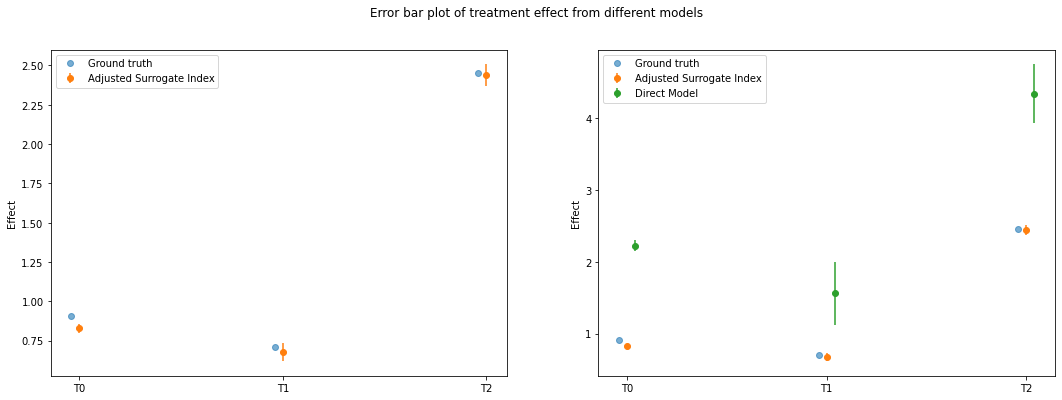

In [25]:
# plot the error bar plot of different models
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)

plt.errorbar(
    np.arange(n_treatments) - 0.04,
    true_longterm_effect,
    fmt="o",
    alpha=0.6,
    label="Ground truth",
)
plt.errorbar(
    np.arange(n_treatments),
    adjsurr_point_est,
    yerr=(
        adjsurr_conf_int_ub - adjsurr_point_est,
        adjsurr_point_est - adjsurr_conf_int_lb,
    ),
    fmt="o",
    label="Adjusted Surrogate Index",
)
plt.xticks(np.arange(n_treatments), ["T0", "T1", "T2"])
plt.ylabel("Effect")
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(
    np.arange(n_treatments) - 0.04,
    true_longterm_effect,
    fmt="o",
    alpha=0.6,
    label="Ground truth",
)
plt.errorbar(
    np.arange(n_treatments),
    adjsurr_point_est,
    yerr=(
        adjsurr_conf_int_ub - adjsurr_point_est,
        adjsurr_point_est - adjsurr_conf_int_lb,
    ),
    fmt="o",
    label="Adjusted Surrogate Index",
)
plt.errorbar(
    np.arange(n_treatments) + 0.04,
    direct_point_est,
    yerr=(direct_conf_int_ub - direct_point_est, direct_point_est - direct_conf_int_lb),
    fmt="o",
    label="Direct Model",
)
plt.xticks(np.arange(n_treatments), ["T0", "T1", "T2"])
plt.ylabel("Effect")
plt.legend()
plt.suptitle("Error bar plot of treatment effect from different models")

We could see the **adjusted surrogate index** approach does a good job overcomes a common data limitation when considering long-term effects of novel treatments and expands the surrogate approach to consider a common, and previously
problematic, pattern of serially correlated treatments.

# Extensions -- Including Heterogeneity in Effect

Finally, I will show that our EconML's `DynamicDML` and `LinearDML` estimators could not only learn Average Treatment Effect (ATE), but also **Heterogeneous Treatment Effect (CATE)**, which will return the treatment effect as a function of interested characteristics. In the example below, I will use first control variable as feature to learn effect heterogeneity, and retrain the final `LinearDML` model. Similarly, you could train `DynamicDML` with feature $X$ as well.

In [31]:
# learn treatment effect on surrogate index on new dataset
from econml.dml import LinearDML

adjsurr_est = LinearDML(
    model_y=LassoCV(max_iter=2000), model_t=MultiTaskLassoCV(max_iter=2000), cv=3
)
# fit treatment_0 on total revenue from new dataset
adjsurr_est.fit(
    sindex_adj, panelTnew[:, 0], X=panelXnew[:, 0, :1], W=panelXnew[:, 0, 1:]
)
# print treatment effect summary
print("True Long-term Effect for each investment: ", true_longterm_effect)
print(
    "Average treatment effect for each investment: ",
    adjsurr_est.const_marginal_ate(panelXnew[:, 0, :1]),
)
adjsurr_est.summary(alpha=0.05)

True Long-term Effect for each investment:  [0.90994672 0.709811   2.45310877]
Average treatment effect for each investment:  [0.82144287 0.70746111 2.69594168]


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0|T0,0.002,0.011,0.203,0.839,-0.019,0.024
X0|T1,0.032,0.033,0.979,0.328,-0.032,0.097
X0|T2,-0.149,0.159,-0.938,0.348,-0.46,0.162
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,0.821,0.014,59.594,0.0,0.794,0.848
cate_intercept|T1,0.708,0.035,19.954,0.0,0.638,0.777
cate_intercept|T2,2.694,0.25,10.793,0.0,2.205,3.184


From the summary table above, none of the coefficient for feature $X0$ is significant, that means there is no effect heterogeneity identified, which is consistent with the data generation process.

# Conclusions

In this notebook, we have demonstrated the power of using EconML to:

* estimate treatment effects in settings when multiple treatments are assigned over time and treatments can have a causal effect on future outcomes
* correct the bias coming from auto-correlation of the historical treatment policy
* use Machine Learning to enable estimation with high-dimensional surrogates and controls
* solve a complex problem using an unified pipeline with only a few lines of code

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/microsoft/EconML) or our [documentation](https://econml.azurewebsites.net/). 